In [1]:
import time
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_mldata
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import random

In [2]:
segment_directory = "data/segmentation.csv"

segment = pd.read_csv(segment_directory, header=0 )


In [3]:
segment.head()

,CustomerId,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,8b4f8c66-7589-4734-8ada-2d42f60540ab,100.40,2019-06-04,6,0.35,0.08,0.609740,0.949383
1,2151b2a2-8867-4986-9e00-449c2b4f89e9,170.00,2019-05-25,4,0.66,0.16,0.942272,0.479846
2,3111db79-6721-4ec0-82b1-30b810649c5e,70.75,2019-05-25,6,0.92,0.20,0.323030,0.007076
3,9cb76426-cc5d-4fa3-88bc-b92314b9f4e8,75.00,2019-03-20,10,0.35,0.78,0.876833,0.088974
4,5d86caeb-2d53-44a7-b379-7f15f06ca821,94.51,2019-04-10,5,0.51,0.44,0.912099,0.206194


Сконвертируем даты из колонки Recency в числа (Unix Time)

In [4]:
import datetime
import time
segment['Recency'] = [time.mktime(datetime.datetime.strptime(item, "%Y-%m-%d").timetuple()) for item in segment['Recency']]

In [5]:
# выкинул колонку с CustomerId, чтобы не мешалась
data = segment.drop(columns='CustomerId')
data.head()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
0,100.40,1.559588e+09,6,0.35,0.08,0.609740,0.949383
1,170.00,1.558724e+09,4,0.66,0.16,0.942272,0.479846
2,70.75,1.558724e+09,6,0.92,0.20,0.323030,0.007076
3,75.00,1.553022e+09,10,0.35,0.78,0.876833,0.088974
4,94.51,1.554836e+09,5,0.51,0.44,0.912099,0.206194


In [6]:
from sklearn.linear_model import HuberRegressor, LinearRegression
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold
import sklearn.metrics

In [7]:
X = data.drop(columns=['Monetary'])
X = pd.DataFrame(normalize(X), columns=X.columns)
y = data['Monetary']
#y = np.log2(y+1)

In [8]:
hr = LinearRegression()
hr.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [9]:
sklearn.metrics.mean_squared_error(y, hr.predict(X))

17465.6116896625

Получили ошибку на предсказании, основанном на всех факторах.

Давайте попробуем выкидывать по одному фактору и оценивать ошибку предсказания, таким образом делая вывод о важности каждого фактора в отдельности

In [10]:
feature_importances_list = []
for dropped_factor in X.columns:
    kf = KFold(n_splits=10)
    sub_X = X.drop(columns=[dropped_factor]).values
    scores = list()
    for train_idx, test_idx in kf.split(sub_X):
        X_train = sub_X[train_idx]
        X_test = sub_X[test_idx]
        
        y_train = y[train_idx]
        y_test = y[test_idx]
        
        model = LinearRegression()
    
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        scores.append(sklearn.metrics.mean_squared_error(y_test, y_pred))
    
    scores = np.array(scores).mean()
    print(dropped_factor, scores)
    
    feature_importances_list.append(
        (dropped_factor, scores)
    )

Recency 16299.530256116874
Frequency 45008.7376896625
factor_1 17484.6703296625
factor_2 17484.366329662498
factor_3 17383.1135296625
factor_4 17383.958169662503


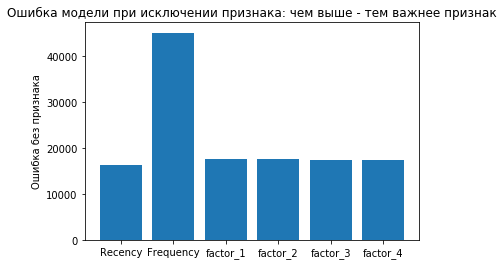

In [11]:
fig, ax = plt.subplots()

factors, values = zip(*feature_importances_list)
ax.bar(factors, values)

ax.set_ylabel('Ошибка без признака')
ax.set_title('Ошибка модели при исключении признака: чем выше - тем важнее признак')

plt.show()

In [12]:
data.describe()

,Monetary,Recency,Frequency,factor_1,factor_2,factor_3,factor_4
count,16000.000000,1.600000e+04,16000.000000,16000.000000,16000.000000,16000.000000,16000.000000
mean,129.972264,1.555538e+09,3.950687,0.500008,0.497864,0.495451,0.498427
std,179.809263,4.426856e+06,5.189864,0.290144,0.291103,0.289034,0.288478
min,0.000000,1.546283e+09,1.000000,0.000000,0.000000,0.000037,0.000033
25%,20.910000,1.552590e+09,1.000000,0.250000,0.240000,0.242545,0.248739
50%,59.275000,1.556305e+09,2.000000,0.500000,0.500000,0.496410,0.498833
75%,170.000000,1.559934e+09,5.000000,0.750000,0.750000,0.744476,0.747424
max,3040.000000,1.560625e+09,111.000000,1.000000,1.000000,0.999996,0.999943


У всех факторов одинаковое среднее и отклонение

In [13]:
from scipy import stats
tested_distribution = 'uniform'
for feature in data.columns:
    result = stats.kstest(data[feature], tested_distribution)

    print(f'Confidence that {feature} has {tested_distribution} distribution = {result.pvalue}')
    

Confidence that Monetary has uniform distribution = 0.0
Confidence that Recency has uniform distribution = 0.0
Confidence that Frequency has uniform distribution = 0.0
Confidence that factor_1 has uniform distribution = 0.03644380222640397
Confidence that factor_2 has uniform distribution = 0.0030128981501947945
Confidence that factor_3 has uniform distribution = 0.14911056132898534
Confidence that factor_4 has uniform distribution = 0.8862015898002251


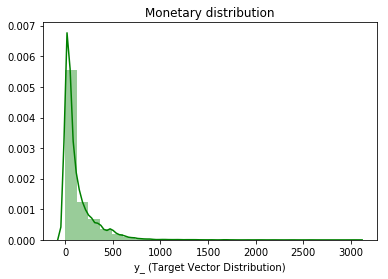

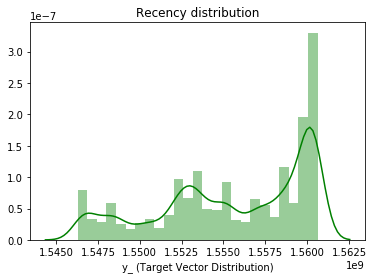

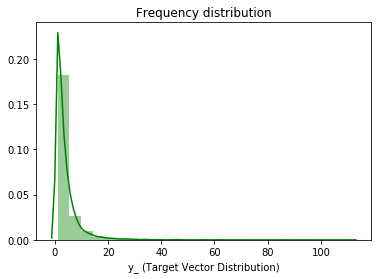

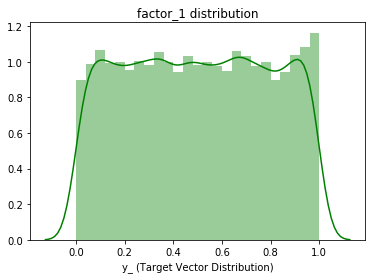

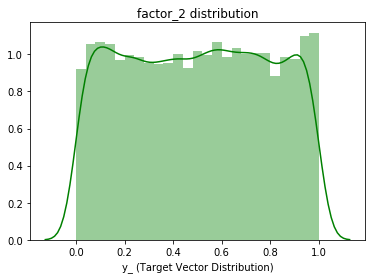

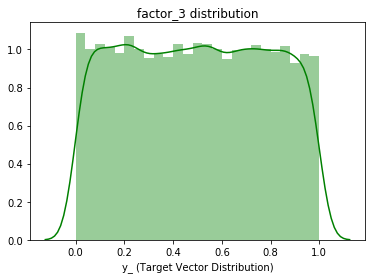

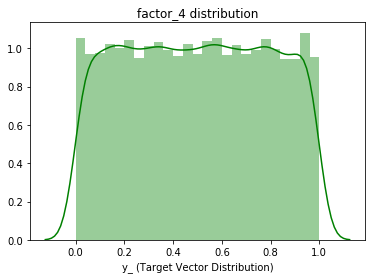

In [14]:
for feature in data.columns:
    y_ = data[feature]
    SR_y = pd.Series(y_, name="y_ (Target Vector Distribution)")
    fig, ax = plt.subplots()
    sns.distplot(SR_y, bins=25, color="g", ax=ax)
    plt.title(f"{feature} distribution")
    plt.show()

Всё равно, кажется, что все колонки factor_... это что-то сгенерированное на равномерном распределении, а не реальные данные 0_о

In [19]:
import scipy
import itertools

In [20]:
list(itertools.combinations(X.columns, 2))

[('Recency', 'Frequency'),
 ('Recency', 'factor_1'),
 ('Recency', 'factor_2'),
 ('Recency', 'factor_3'),
 ('Recency', 'factor_4'),
 ('Frequency', 'factor_1'),
 ('Frequency', 'factor_2'),
 ('Frequency', 'factor_3'),
 ('Frequency', 'factor_4'),
 ('factor_1', 'factor_2'),
 ('factor_1', 'factor_3'),
 ('factor_1', 'factor_4'),
 ('factor_2', 'factor_3'),
 ('factor_2', 'factor_4'),
 ('factor_3', 'factor_4')]

In [21]:
correlations = []
for f1, f2 in itertools.combinations(X.columns, 2):
    correlation, p = scipy.stats.pearsonr(data[f1], data[f2])
    correlations.append({
        'f1': f1,
        'f2': f2,
        'corellation': correlation,
        'p-value': p,
        'confidence': p < 0.05
    })
correlations = pd.DataFrame(correlations)
correlations.reindex(correlations.corellation.abs().sort_values().index)

,confidence,corellation,f1,f2,p-value
5,False,0.000180,Frequency,factor_1,9.818785e-01
6,False,-0.000392,Frequency,factor_2,9.604130e-01
10,False,-0.000411,factor_1,factor_3,9.585140e-01
4,False,0.001852,Recency,factor_4,8.147657e-01
1,False,-0.002042,Recency,factor_1,7.961488e-01
14,False,-0.003524,factor_3,factor_4,6.558328e-01
8,False,0.005112,Frequency,factor_4,5.179365e-01
9,False,-0.005630,factor_1,factor_2,4.764362e-01
7,False,0.006420,Frequency,factor_3,4.167593e-01
12,False,0.006977,factor_2,factor_3,3.775266e-01


Зависимостей между переменными тоже нет :(

In [22]:
from sklearn.cluster import KMeans
scores = []
for n in range(2, 15):
    knn = KMeans(n_clusters=n, algorithm='full', n_jobs=-1)
    knn.fit(data)
    scores.append(
        (n, knn.inertia_)
    )

K для kNN следует выбирать такой, на котором идёт существенное снижение расстояния от объектов кластера до соответсвующего центроида 

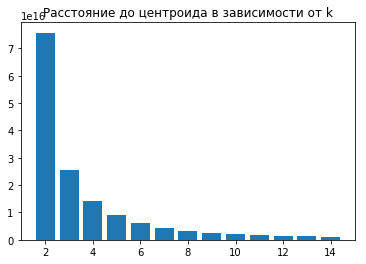

In [23]:
fig, ax = plt.subplots()

factors, values = zip(*scores)
ax.bar(factors, values)

ax.set_title('Расстояние до центроида в зависимости от k')

plt.show()

Соотвественно, выбираем k = 3

In [24]:
knn = KMeans(n_clusters=3, algorithm='full', n_jobs=-1)
knn.fit(data)

KMeans(algorithm='full', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=3, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [25]:
clusters = knn.predict(data)
data['cluster'] = clusters

Превратим UnixTime обратнов в datetime

In [26]:
data['Recency'] = [datetime.datetime.fromtimestamp(time) for time in data['Recency']]

Посмотрим на время последнего платежа каждого из кластеров:

In [27]:
data[data['cluster'] == 0]['Recency'].value_counts()[:10]

2019-03-22    302
2019-03-15    266
2019-04-12    246
2019-03-23    226
2019-03-24    179
2019-03-16    165
2019-04-13    165
2019-04-14    161
2019-03-12    153
2019-03-09    151
Name: Recency, dtype: int64

In [28]:
data[data['cluster'] == 1]['Recency'].value_counts()[:10]

2019-06-14    686
2019-06-15    658
2019-06-09    629
2019-06-16    429
2019-06-08    402
2019-06-07    398
2019-06-12    344
2019-06-13    311
2019-06-10    305
2019-06-11    297
Name: Recency, dtype: int64

In [29]:
data[data['cluster'] == 2]['Recency'].value_counts()[:10]

2019-01-05    187
2019-01-04    176
2019-01-26    153
2019-01-25    147
2019-01-06    122
2019-01-27    117
2019-01-07     86
2019-02-16     76
2019-02-15     75
2019-02-20     73
Name: Recency, dtype: int64

Видим, что действительно, время последнего платежа действительно значимо отличается в каждом из кластеров:

В первом кластере платежи за март и апрель

Во втором - июнь

В третьем - январь и февраль

Посмотрим на статистики данные разных кластеров

In [33]:
data[data['cluster'] == 0].describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,cluster
count,5293.000000,5293.000000,5293.000000,5293.000000,5293.000000,5293.000000,5293.0
mean,102.863433,3.308332,0.502569,0.504034,0.500953,0.499637,0.0
std,139.351266,3.798018,0.289077,0.289329,0.290489,0.288939,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000037,0.000033,0.0
25%,20.020000,1.000000,0.260000,0.250000,0.245317,0.247794,0.0
50%,49.620000,2.000000,0.500000,0.510000,0.504281,0.497907,0.0
75%,125.000000,4.000000,0.750000,0.750000,0.751825,0.747295,0.0
max,1660.000000,57.000000,1.000000,1.000000,0.999996,0.999943,0.0


In [34]:
data[data['cluster'] == 1].describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,cluster
count,7914.000000,7914.000000,7914.000000,7914.000000,7914.000000,7914.000000,7914.0
mean,171.640430,5.058630,0.498361,0.497602,0.490971,0.498432,1.0
std,210.876316,6.305332,0.290586,0.292138,0.289178,0.287655,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000136,0.000412,1.0
25%,30.020000,2.000000,0.250000,0.240000,0.238159,0.250508,1.0
50%,102.440000,3.000000,0.500000,0.500000,0.487622,0.500426,1.0
75%,238.570000,6.000000,0.750000,0.750000,0.740694,0.746548,1.0
max,3040.000000,111.000000,1.000000,1.000000,0.999923,0.999898,1.0


In [35]:
data[data['cluster'] == 2].describe()

,Monetary,Frequency,factor_1,factor_2,factor_3,factor_4,cluster
count,2793.000000,2793.000000,2793.000000,2793.000000,2793.000000,2793.000000,2793.0
mean,63.278808,2.028643,0.499821,0.486914,0.497716,0.496119,2.0
std,108.006846,2.523224,0.290977,0.291290,0.285741,0.290018,0.0
min,0.000000,1.000000,0.000000,0.000000,0.000176,0.000159,2.0
25%,13.420000,1.000000,0.250000,0.230000,0.245899,0.245991,2.0
50%,21.410000,1.000000,0.500000,0.490000,0.502857,0.495553,2.0
75%,60.010000,2.000000,0.750000,0.730000,0.738690,0.750300,2.0
max,1364.000000,61.000000,1.000000,1.000000,0.999992,0.999517,2.0


Видим, что статистики признаков factor_1, factor_2, factor_3, factor_4 не отличаются друг от друга, поэтому я делаю вывод о том, что они все не значимы

<b>Ответ</b>: factor_1, factor_2, factor_3, factor_4

In [39]:
data_0 = data[data['cluster'] == 0]
data_1 = data[data['cluster'] == 1]
data_2 = data[data['cluster'] == 2]

### Визуализация кластеров

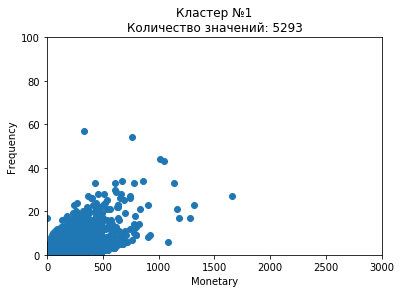

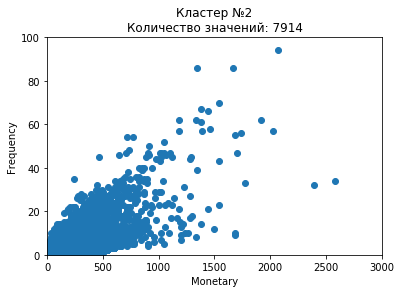

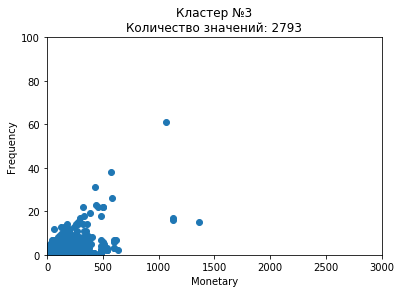

In [59]:
for idx, cluster in enumerate([data_0, data_1, data_2]):
    plt.title(f'Кластер №{idx+1}\nКоличество значений: {cluster.shape[0]}')
    
    plt.xlim(0, 3000)
    plt.ylim(0, 100)
    
    plt.xlabel('Monetary')
    plt.ylabel('Frequency')
    plt.scatter(x=cluster['Monetary'], y=cluster['Frequency'])
    plt.show()

На основе имеющихся данных можно сделать такой вывод:
В первом кластере платежи за март и апрель

1. Кластер №3 - неактивные пользователи (в основном платежи на январь и февраль, платежей мало)
2. Кластер №2 и №1 - похожие пользователи, только в кластере #2 пользователи совершали платёж совсем недавно - в июне, а в первом за март и апрель, и в кластере №2 разброс гораздо выше

Скорее всего, имеет смысл разбить данные аккуратнее, соединить второй и первый кластер вместе, а выбросы - в отдельный кластер


Тогда получится 3 кластера активных пользователей, неактивных пользователей, и активных пользователей, от которых приходит сущетвенная доля объёма средств.